In [1]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
real_data = "CrossMatch"
altered_data = "AMSL_SynFP_SGR_v1/crossmatch_andrey_512_seeds1-50000"

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609

In [2]:
data = []
labels = []

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
photos_names = os.listdir(altered_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(altered_data, name) ,cv.IMREAD_GRAYSCALE))
    labels.append(1)

In [3]:
x = 96
y = 103

In [4]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

In [5]:
train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
# print the shape of the data for each image
i = 0
for image in train_data:
    if image.shape != (y, x, 1):
        i += 1
print('images without the correct shape: ', i)

images without the correct shape:  0


[1]


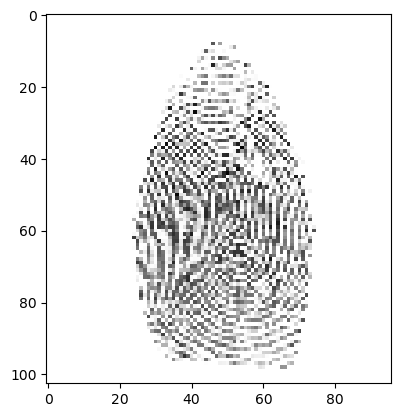

In [7]:
# visualization of 1 image from train data
import matplotlib.pyplot as plt
print(train_labels[1])
plt.imshow(train_data[1], cmap='gray')
plt.show()

In [6]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

### Using Cross Entropy loss

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
1009/1009 [==============================] - 45s 37ms/step - loss: 0.2001 - accuracy: 0.9923 - val_loss: 0.0476 - val_accuracy: 0.9964
Epoch 2/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0235 - accuracy: 0.9970 - val_loss: 0.0433 - val_accuracy: 0.9962
Epoch 3/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.1233 - val_accuracy: 0.9928
Epoch 4/10
1009/1009 [==============================] - 35s 35ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 0.0163 - val_accuracy: 0.9948
Epoch 5/10
1009/1009 [==============================] - 35s 34ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.0124 - val_accuracy: 0.9976
Epoch 6/10
1009/1009 [==============================] - 35s 35ms/step - loss: 0.0177 - accuracy: 0.9975 - val_loss: 0.0109 - val_accuracy: 0.9969
Epoch 7/10
1009/1009 [==============================] - 35s 34ms/step - loss: 0.0174 - accuracy: 0.9974 - val_loss: 0.0239 -

In [8]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

316/316 [==============================] - 9s 26ms/step
Balanced Accuracy: 0.897110408851212
Confusion Matrix: 
[[   58    15]
 [    3 10006]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.87        73
           1       1.00      1.00      1.00     10009

    accuracy                           1.00     10082
   macro avg       0.97      0.90      0.93     10082
weighted avg       1.00      1.00      1.00     10082



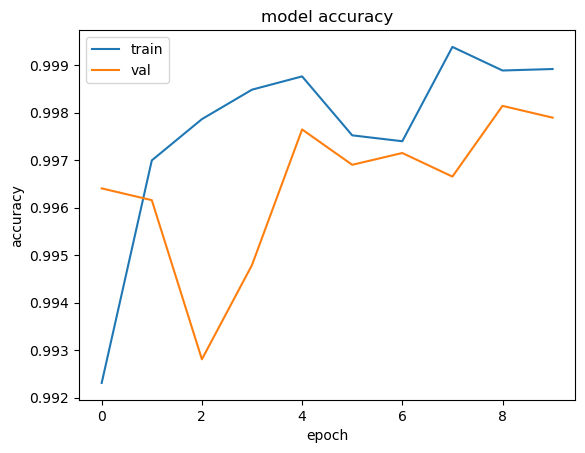

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Accuracy metric

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1009/1009 [==============================] - 46s 39ms/step - loss: 0.2255 - binary_accuracy: 0.9918 - val_loss: 0.0402 - val_binary_accuracy: 0.9965
Epoch 2/10
1009/1009 [==============================] - 39s 39ms/step - loss: 0.0239 - binary_accuracy: 0.9963 - val_loss: 0.0098 - val_binary_accuracy: 0.9978
Epoch 3/10
1009/1009 [==============================] - 36s 36ms/step - loss: 0.0085 - binary_accuracy: 0.9984 - val_loss: 0.0168 - val_binary_accuracy: 0.9965
Epoch 4/10
1009/1009 [==============================] - 37s 37ms/step - loss: 0.0045 - binary_accuracy: 0.9989 - val_loss: 0.0082 - val_binary_accuracy: 0.9981
Epoch 5/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0079 - binary_accuracy: 0.9981 - val_loss: 0.0138 - val_binary_accuracy: 0.9965
Epoch 6/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0063 - binary_accuracy: 0.9987 - val_loss: 0.0115 - val_binary_accuracy: 0.9981
Epoch 7/10
1009/1009 [==================

In [8]:

y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

316/316 [==============================] - 9s 27ms/step
Balanced Accuracy: 0.7671232876712328
Confusion Matrix: 
[[   39    34]
 [    0 10009]]
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        73
           1       1.00      1.00      1.00     10009

    accuracy                           1.00     10082
   macro avg       1.00      0.77      0.85     10082
weighted avg       1.00      1.00      1.00     10082



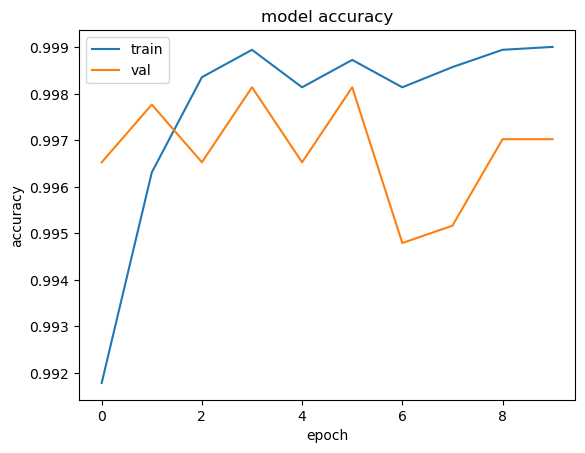

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Image Random Flip

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Input, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom, RandomCrop
import tensorflow as tf

# Input layer with the shape of your data
input_tensor = Input(shape=(y, x, 3))

# Data augmentation layers
x = RandomFlip("horizontal")(input_tensor)
x = RandomRotation(0.2)(x)  # Adjust the rotation range as needed
x = RandomZoom(0.2)(x)  # Adjust the zoom range as needed

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=input_tensor, outputs=predictions)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1009/1009 [==============================] - 177s 165ms/step - loss: 0.0329 - binary_accuracy: 0.9906 - val_loss: 0.0143 - val_binary_accuracy: 0.9917
Epoch 2/10
1009/1009 [==============================] - 164s 162ms/step - loss: 0.0084 - binary_accuracy: 0.9939 - val_loss: 0.0128 - val_binary_accuracy: 0.9934
Epoch 3/10
1009/1009 [==============================] - 164s 162ms/step - loss: 0.0074 - binary_accuracy: 0.9941 - val_loss: 0.0096 - val_binary_accuracy: 0.9934
Epoch 4/10
1009/1009 [==============================] - 162s 160ms/step - loss: 0.0062 - binary_accuracy: 0.9952 - val_loss: 0.0113 - val_binary_accuracy: 0.9921
Epoch 5/10
1009/1009 [==============================] - 163s 162ms/step - loss: 0.0060 - binary_accuracy: 0.9953 - val_loss: 0.0100 - val_binary_accuracy: 0.9926
Epoch 6/10
1009/1009 [==============================] - 188s 186ms/step - loss: 0.0057 - binary_accuracy: 0.9951 - val_loss: 0.0116 - val_binary_accuracy: 0.9926
Epoch 7/10
1009/1009 [======

In [9]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

316/316 [==============================] - 9s 30ms/step
Balanced Accuracy: 0.6162884910429928
Confusion Matrix: 
[[   17    56]
 [    3 10006]]
              precision    recall  f1-score   support

           0       0.85      0.23      0.37        73
           1       0.99      1.00      1.00     10009

    accuracy                           0.99     10082
   macro avg       0.92      0.62      0.68     10082
weighted avg       0.99      0.99      0.99     10082



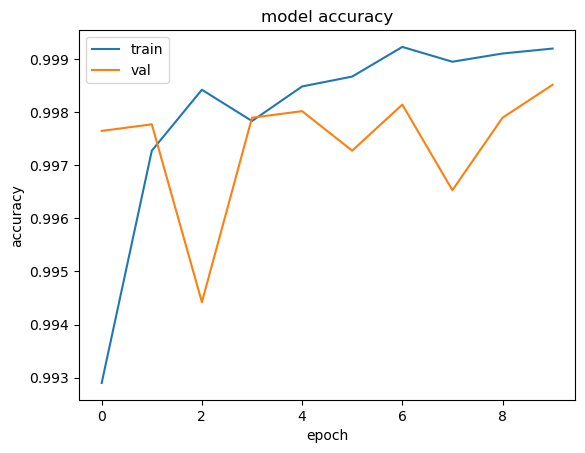

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Focal loss

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal_and_vertical")(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [8]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


c:\Users\Alexandre\anaconda3\envs\tfnn\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1009/1009 [==============================] - 45s 38ms/step - loss: 0.1214 - binary_accuracy: 0.9881 - val_loss: 0.0051 - val_binary_accuracy: 0.9962
Epoch 2/10
1009/1009 [==============================] - 37s 37ms/step - loss: 0.0034 - binary_accuracy: 0.9970 - val_loss: 0.0046 - val_binary_accuracy: 0.9976
Epoch 3/10
1009/1009 [==============================] - 37s 37ms/step - loss: 0.0027 - binary_accuracy: 0.9978 - val_loss: 0.0093 - val_binary_accuracy: 0.9968
Epoch 4/10
1009/1009 [==============================] - 37s 37ms/step - loss: 0.0025 - binary_accuracy: 0.9980 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 5/10
1009/1009 [==============================] - 37s 37ms/step - loss: 0.0013 - binary_accuracy: 0.9987 - val_loss: 0.0070 - val_binary_accuracy: 0.9974
Epoch 6/10
1009/1009 [==============================] - 37s 37ms/step - loss: 0.0012 - binary_accuracy: 0.9987 - val_loss: 0.0048 - val_binary_accuracy: 0.9979
Epoch 7/10
1009/1009 [=============================

In [10]:
y_pred = model.predict(test_data_3)

316/316 [==============================] - 8s 23ms/step


In [11]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred)))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

0.8698630136986301
Confusion Matrix: 
[[   54    19]
 [    0 10009]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        73
           1       1.00      1.00      1.00     10009

    accuracy                           1.00     10082
   macro avg       1.00      0.87      0.92     10082
weighted avg       1.00      1.00      1.00     10082



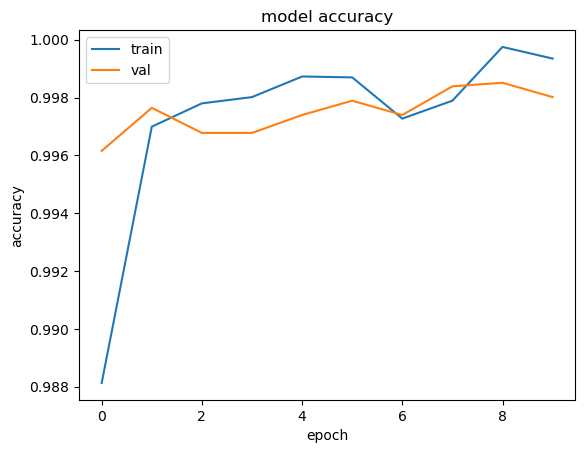

In [12]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Balanced Classes

In [2]:
import random

data = []
labels = []
random.seed(42)

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
limit = len(data)*2
dir_list = os.listdir(altered_data)
photos_names = random.choices(population=dir_list, k=limit)
for name in photos_names:
    data.append(cv.imread(os.path.join(altered_data, name) ,cv.IMREAD_GRAYSCALE))
    labels.append(1)


In [3]:
x = 96
y = 103

# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

In [4]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [5]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


c:\Users\Alexandre\anaconda3\envs\tfnn\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 8s 70ms/step - loss: 2.2527 - binary_accuracy: 0.6386 - val_loss: 0.2117 - val_binary_accuracy: 0.8673
Epoch 2/20
25/25 [==============================] - 1s 37ms/step - loss: 0.1215 - binary_accuracy: 0.9119 - val_loss: 0.0922 - val_binary_accuracy: 0.9184
Epoch 3/20
25/25 [==============================] - 1s 35ms/step - loss: 0.0501 - binary_accuracy: 0.9579 - val_loss: 0.0423 - val_binary_accuracy: 0.9388
Epoch 4/20
25/25 [==============================] - 1s 36ms/step - loss: 0.0232 - binary_accuracy: 0.9681 - val_loss: 0.0623 - val_binary_accuracy: 0.9286
Epoch 5/20
25/25 [==============================] - 1s 36ms/step - loss: 0.0150 - binary_accuracy: 0.9719 - val_loss: 0.0643 - val_binary_accuracy: 0.9694
Epoch 6/20
25/25 [==============================] - 1s 36ms/step - loss: 0.0059 - binary_accuracy: 0.9872 - val_loss: 0.0344 - val_binary_accuracy: 0.9745
Epoch 7/20
25/25 [==============================] - 1s 35ms/step - loss: 0.0025 -

In [6]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(test_data_3)

print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

8/8 [==============================] - 1s 35ms/step
Balanced Accuracy: 0.9292885202968136
Confusion Matrix: 
[[ 78   9]
 [  6 152]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        87
           1       0.94      0.96      0.95       158

    accuracy                           0.94       245
   macro avg       0.94      0.93      0.93       245
weighted avg       0.94      0.94      0.94       245



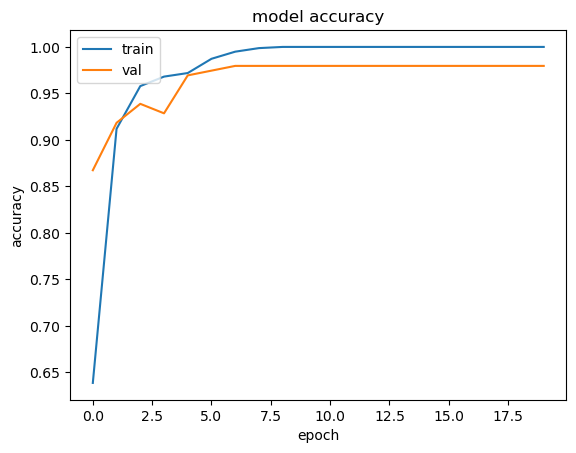

In [8]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
model.save('synFP.h5') 